## Imports

The following code shell shows the imports of the libraries we have used for model A. These imports are used to bring in external libraries or modules that provide additional functionality to the program. These libraries can be used to perform specific tasks, such as data manipulation, visualization, or machine learning. The import statement is used to load the library or module into the current program, making its functions and classes available for use. In some cases, specific functions or classes can be imported from a library to reduce memory usage and improve program performance.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.feature_selection import RFE
from sklearn.metrics import mean_squared_error, PredictionErrorDisplay
from sklearn.tree import DecisionTreeRegressor
from sklearn import decomposition, tree
from sklearn.model_selection import GridSearchCV, RepeatedKFold, train_test_split, RandomizedSearchCV
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import loguniform

import warnings
warnings.filterwarnings("ignore")

## Data loading

Loading data from CSV (Comma Separated Values) files is a common task in data analysis and machine learning. CSV files are a simple way to store data in a tabular format, where each row represents an observation and each column represents a variable. Pandas library allow us to read CSV files and convert them into data frames. We load the training and test data from the CSV files and build a dataframe with the corresponding datatypes of the columns. Additionally, we add three new columns (year, month, day) that we will use further on.


In [2]:
DS_PATH_TRAIN = "realestate_train.csv"
DS_PATH_TEST = "realestate_test.csv"

types = {"price": np.uint32,
         "type": str,
         "bedrooms": np.uint8}

color_palette = lambda vals: sns.color_palette("coolwarm", vals)

#Importing Test Data

df_test = pd.read_csv(DS_PATH_TEST, 
                        dtype=types, 
                        parse_dates=["date"])

df_test["year"] = df_test["date"].dt.year
df_test["month"] = df_test["date"].dt.month
df_test["day"] = df_test["date"].dt.day

# Importing Training Data

df = pd.read_csv(DS_PATH_TRAIN, 
                        dtype=types, 
                        parse_dates=["date"])

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month
df["day"] = df["date"].dt.day

## Data preparation

Data preparation is a crucial step in the machine learning process that involves cleaning, transforming, and pre-processing raw data to make it suitable for use in a machine learning model. The main goal of data preparation is to ensure that the data is accurate, complete, and relevant to the problem at hand. This involves removing any missing or duplicate values, dealing with outliers, scaling and normalizing the data, and encoding categorical variables.

### Data analysis

After loading the proper data, we are ready to visualize the distribution of the price for both datasets to determine outliers. A plot of the number of properties according to prices is a common visualization used in the real estate industry to understand the distribution of property prices in a given area. This type of plot shows the number of properties on the y-axis and the price range on the x-axis. 
We will make use of the seaborn library in order to generate this kind of graph with the test data according to price.

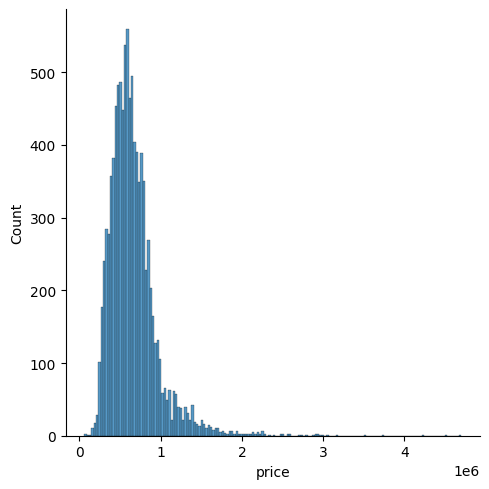

In [3]:
#insights into the distribution - Test Data set
sns.displot(df_test, x="price")

Now, we will use the seaborn library again to visualize the training data. The resulting graph reveals important insights into the local real estate market. It is reasonable to assume that the properties with a price higher than 1 million are not a representative part from the data. Therefore, we can define them as outliers and get rid of them at the data preparation. 


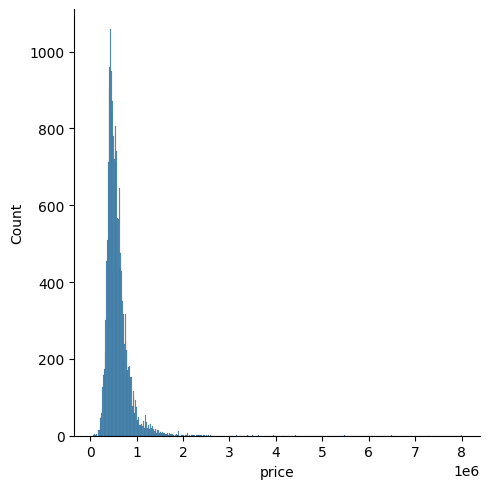

In [4]:
#Training Data Set
sns.displot(df, x="price")

Finally, we make use of a correlation heatmap which is a useful tool for identifying pattern and relationships between variables in a dataset. In the case of a dataset that includes both housing prices and the number of bedrooms in each home, a correlation heatmap can be used to determine if there is a relationship between these two variables. The heatmap shows a strong positive correlation between price and bedrooms, this indicates that homes with more bedrooms tend to have higher prices.  

Text(0.5, 1.0, 'Correlation Heatmap for the Training set')

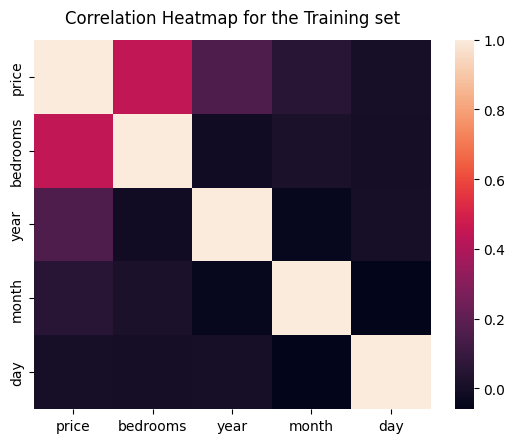

In [5]:
heatmap = sns.heatmap(df.corr())
heatmap.set_title('Correlation Heatmap for the Training set', fontdict={'fontsize':12}, pad=12)

### Data cleaning

Data cleaning is an important step in the machine learning process as the quality of the data determines the accuracy and effectiveness of the model. It involves identifying and correcting inaccuracies, inconsistencies, and missing information in the dataset. The process involves various techniques including removing or imputing missing data, identifying and eliminating duplicate entries, correcting errors, handling outliers and transforming data into a usable format for analysis. Data cleaning helps to remove biases, ensure data integrity and improve the quality of the dataset. It is a time-consuming process but necessary for building robust and accurate machine learning models.

Therefore, after the data anylysis been made, we get rid of the outliers by removing the properties with no berooms and a price higher than 1 million. 

In [6]:
#Data cleaning
def data_cleaning(df: pd.DataFrame) -> pd.DataFrame:
    return df[(df['bedrooms'] >= 1) & (df['price'] <= 1000000)].copy()

### Feature Engineering


Feature engineering is a process of preparing variables or features that are used as input in machine learning models. This process involves selecting, creating, and transforming variables to achieve optimal model performance. Feature engineering requires a deep understanding of the problem domain, machine learning algorithms, and data. It involves techniques such as scaling, normalization, and one-hot encoding, as well as the creation of new variables derived from existing ones through mathematical operations or other data processing techniques. Feature engineering plays a critical role in the success of predictive modeling by improving model accuracy, reducing overfitting, and increasing interpretability. 

It requires a combination of knowledge, creativity, and resourcefulness to extract useful insights from data that are relevant to the problem at hand. Moreover, we start the feature engineering by implementing the scaler and creating new different features based on the ones given in the file:

1. The mean price per bedroom
2. The price scaled
3. The mean price per bedroom of the previous entry
4. The mean price per bedroom 

3. The delta between the relevant mean bedroom price and the mean bedroom price of the previous entry
4. The bedrooms scaled
5. The mean price per bedroom scaled
6. The mean price per bedroom of the previous entry scaled
7. The delta between the relevant mean bedroom price and the mean bedroom price of the previous entry scaled
8. The monthly mean price

While the the feature engineering process is essential to this task, we are aware that most of our engineered features find little to no use in the prediction, as they inherit information about the target, thus making it obsolete to use them in the regression tasks.

In [7]:
scaler = RobustScaler()
def feature_engineering(df: pd.DataFrame) -> pd.DataFrame:
    df['meanPricePB'] = df['price'] / df['bedrooms']
    df['price_scaled'] = scaler.fit_transform(df[['price']])
    df['prevMeanPricePB'] = df['meanPricePB'].shift(1)
    df['meanPricePB_shift2'] = df['meanPricePB'].shift(2)
    df['meanPricePB_shift3'] = df['meanPricePB'].shift(3)
    df['meanPriceDeltaToYesterday'] = df['meanPricePB'] - df['prevMeanPricePB']
    df['bedrooms_scaled'] = scaler.fit_transform(df[['bedrooms']])
    df['meanPricePB_scaled'] = scaler.fit_transform(df[['meanPricePB']])
    df['prevMeanPricePB_scaled'] = scaler.fit_transform(df[['prevMeanPricePB']])
    # df['meanPricePB_shift2_scaled'] = scaler.fit_transform(df['meanPricePB_shift2'])
    # df['meanPricePB_shift3_scaled'] = scaler.fit_transform(df['meanPricePB_shift3'])
    df['meanPriceDeltaToYesterday_scaled'] = scaler.fit_transform(df[['meanPriceDeltaToYesterday']])
    df = pd.concat([df, pd.get_dummies(df['type'], drop_first=True)], axis = 1)
    df['date_month'] = df['date'].values.astype('datetime64[M]')
    df['monthlyMeanPrice'] = df['price']
    sales_month = df.groupby(['date_month'])[['monthlyMeanPrice']].agg('mean').reset_index()
    df = df.merge(sales_month, how='left', on=['date_month'])
    df = df.drop(columns=['monthlyMeanPrice_x'])
    df = df.rename(columns={"monthlyMeanPrice_y": "monthlyMeanPrice"})
    df['monthlyMeanPrice_scaled'] = scaler.fit_transform(df[['monthlyMeanPrice']])
    return df[~df.isnull().any(axis=1)]

### Data evaluation

We are going to apply the data preparation and the feature engineering to both datasets, training and test datasets, and take a deeper look into the price per bedrooms.



<Axes: xlabel='bedrooms', ylabel='price'>

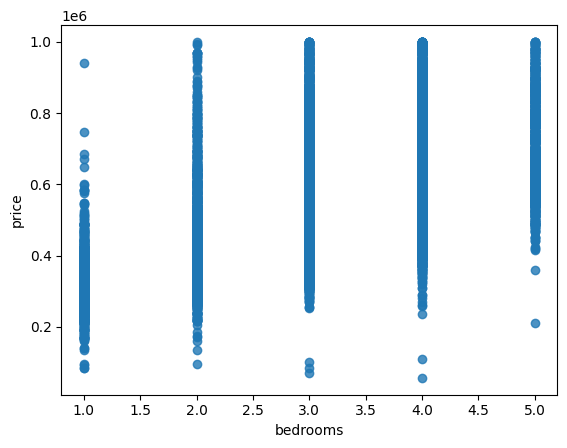

In [8]:
#First insight into the data

df_train = data_cleaning(df)
df_train = feature_engineering(df_train)

df_train.head()

df_test = data_cleaning(df_test)
df_test = feature_engineering(df_test)

df_viz = df_train.loc[:, ['bedrooms', 'price']]
sns.regplot(x="bedrooms", y="price", data=df_viz, fit_reg=False)

Additionally, we will make use of a correlation heatmap for the training dataset after the feature engineering to determine if there is a relationship between two variables in the dataset. 



Text(0.5, 1.0, 'Correlation Heatmap for the Training set after Feature Engineering')

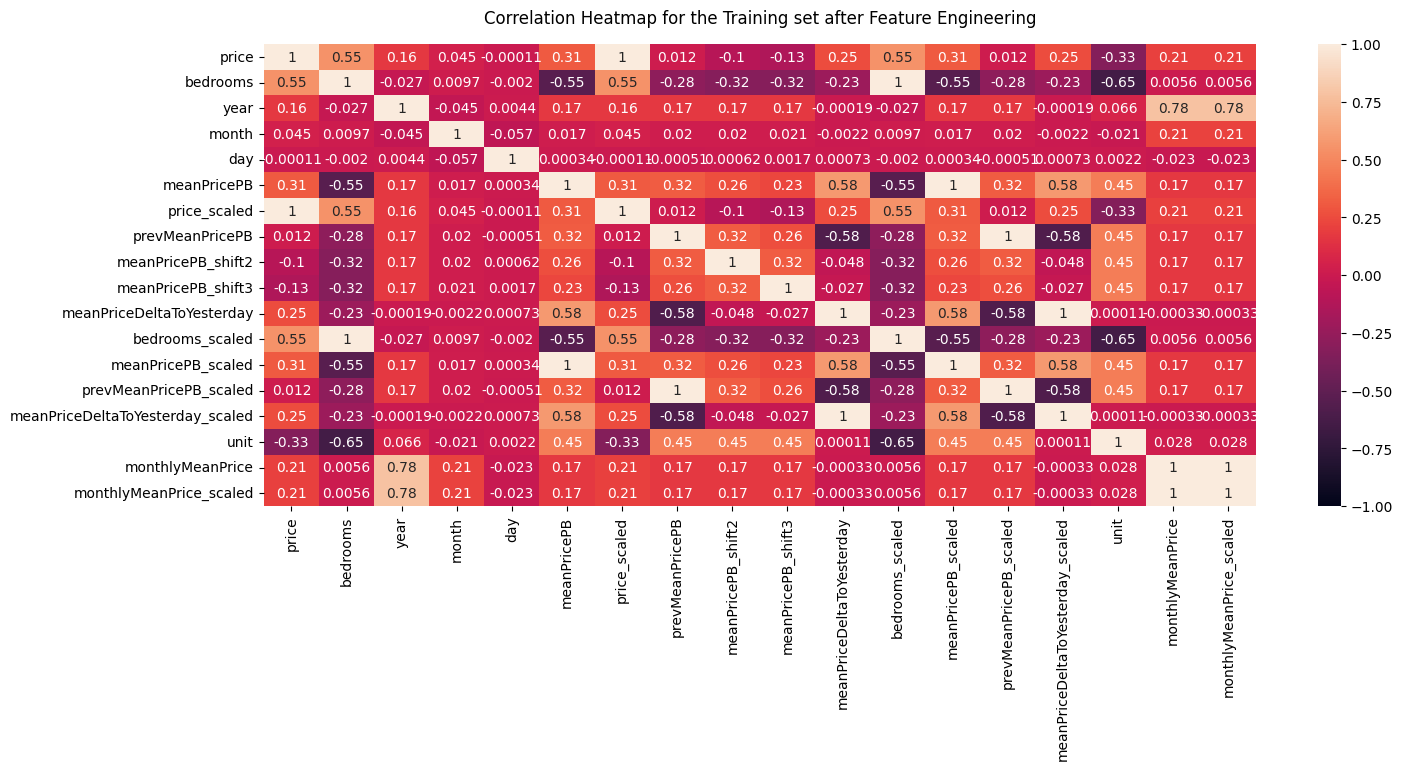

In [9]:
plt.figure(figsize=(16, 6))
heatmap = sns.heatmap(df_train.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap for the Training set after Feature Engineering', fontdict={'fontsize':12}, pad=15)

## Model


In this part we split the training data set. This is so that the different models do not get insight into the target/test data.

In [10]:
X = df_train[['bedrooms','unit','year','month']]
X = np.array(X)
Y=df_train['price']
Y = np.array(Y)

Y=Y.reshape(-1,1)
x_train, x_test, y_train, y_test = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

**Model Selection & Hyperparameter tuning**

As previously stated, the given data and the inherited features are sparse. This left us with the wish to try different regression models and approaches to ensure that the resulting predictions and performances can be compared and a reliable conclusion can be formulated. 
The selected regression models for this task are:
1. Ridge Regression
2. Linear Regression
3. Support Vector Regression
4. Decision Tree Classification
5. Random Forest Regression

In order to guarantee that all of the models are applied correctly, a hyperparameter tuning process was implemented for each model. While the Ridge and the Random Forest model both use RandomSearch to determine the best hyperparameters, the other regression models and the decision tree classification make use of girdSearch. All of the tuning processes make use of crossvalidation, to ensure reliable results. 
As a performance score the R2 score is chosen, as it depicts the similarity of predictions to the actual values and can be applied to both search models.

After the hyperparameter tuning is done, the best estimators for each model will be used for the final models and the prediction task.

**Ridge Regression**

While the previous correlation matrix indicates that the given features mostly do not have high correlations between each other, a ridge regression is installed to guarantee that the multicollinearity problem is mitigated, before implementing a linear regression model. However the probability for this problem to arise should be relatively low, since the provided data has few features.

The used solvers were chosen to cover a large variety of different approaches, including the 'auto' option, which automatically decides for a fitting solver based on the given data. We assign a random generated searchspace to alpha and define the intercept parameter.

Furthermore we define a k-fold cross-validation with 10 splits for the tuning, to gain insight into the performance of the model. The number of splits and repeats was chosen moderately, as the number of features given is sparce.

The resulting perofmance with a R2 score of 0.34, seems to be relatively good, since the price values revolve around the houndred thousands.

In [11]:
#Hyperparameter Tuning for Ridge
model = Ridge()

space = dict()
space['solver'] = ['auto', 'svd', 'cholesky', 'lsqr', 'sag']
space['alpha'] = loguniform(1e-5, 100)
space['fit_intercept'] = [True, False]

cv = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)
search = RandomizedSearchCV(model, space, n_iter=500, scoring='r2', n_jobs=-1, cv=cv, random_state=1)
search.fit(x_train, y_train)

print(f"Best hyperparameters for ridge: {search.best_params_}")
print(f"Best score for ridge: {search.best_score_}")

/Users/luisalves/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/luisalves/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/luisalves/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/luisalves/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/luisalves/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not conver

Best hyperparameters for ridge: {'alpha': 10.974431695130143, 'fit_intercept': True, 'solver': 'sag'}
Best score for ridge: 0.34083020713008777


/Users/luisalves/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/luisalves/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


**Linear Regression**

Based on the given data, a linear regression model could prove be sufficient enough to extract viable results. As it is a widely used and simple approach to regression, it is also implemented. 

For this model we also used a k-fold cross-validation with the same settings as for the Ridge regression, to ensure comparability.

The results for the linear regression are equal to the ridge score with a R2 score of 0.34.

In [12]:
#Hyperparameter Tuning for Linear Regression
lr = LinearRegression()
param_grid = {
    'fit_intercept': [True, False],
    'copy_X': [True, False],
    'n_jobs': [None, -1]
}
cvr = RepeatedKFold(n_splits=5, n_repeats=10, random_state=42)

grid_search = GridSearchCV(lr, param_grid=param_grid, cv=cvr, scoring='r2')
grid_search.fit(x_train, y_train)

print(f"Best hyperparameters for lr: {grid_search.best_params_}")
print(f"Best score for lr: {grid_search.best_score_}")

Best hyperparameters for lr: {'copy_X': True, 'fit_intercept': True, 'n_jobs': None}
Best score for lr: 0.3409630326364066


**Decision Tree Classification**

A decision tree classification is implemented to ensure that not only regression tasks are used to predict the target value. In this case the simplest form of tree classification is implemented. 

For the grid search process we define a scaler for the data, principal component analysis in order to decompose the data and the classifier. After the number of components is assigned based on the features. The criteria gini and entropy are chosen, as they should cover the needed classification spectrum for the given data. Lastly the depth of the tree is defined.

The decision tree is then fit to the data and the resulting R2 score depicts a value of 0.92, which is the highest so far. However the decision tree classification is known to overfit, hence this score should be interpreted with special regard.

In [13]:
#Hyperparameter tuning for Decision Tree
std_slc = StandardScaler()
pca = decomposition.PCA()
dec_tree = tree.DecisionTreeClassifier()

pipe = Pipeline(steps=[('std_slc', std_slc),('pca', pca),('dec_tree', dec_tree)])
n_components = list(range(1,X.shape[1]+1,1))
criterion = ['gini', 'entropy']
max_depth = [2,4,6,8,10,12,14,16,20]

parameters = dict(pca__n_components=n_components,dec_tree__criterion=criterion,dec_tree__max_depth=max_depth)

clf_GS = GridSearchCV(pipe, parameters, cv=3, scoring='r2')
clf_GS.fit(X, Y)
print('Best Criterion for dt:', clf_GS.best_estimator_.get_params()['dec_tree__criterion'])
print('Best max_depth for dt:', clf_GS.best_estimator_.get_params()['dec_tree__max_depth'])
print('Best Number Of Components:', clf_GS.best_estimator_.get_params()['pca__n_components'])
print(f"Best score for DT: {clf_GS.best_score_}")

Best Criterion for dt: gini
Best max_depth for dt: 4
Best Number Of Components: 2


**Support Vector Regression**

The support vector model was chosen as it is extremely robust to outliers and it performs well with smaller data sets. While the upper outliers were removed before, the lower outliers are still included. 

Concerning the parameters for the hyperparameter tuning, the C values are changed from default to ensure a wider coverage of regularization options, same for the gamma score. Regarding the kernels, again a linear approach is included to see compare another approach to the previous ones, while also including the radial basis function and sigmoid kernel to ensure a variety of approaches. The polynomial kernel was also implemented throughout the previous versions but severly effected the computational performance, while not yielding better results.

The SVR model is then fitted to the data, resulting in a R2 score of 0.012, being the worst performing approach so far.

In [14]:
#Hyperparameter Tuning for the SVR
param_grid_SVR = {'C': [0.01, 0.1, 1], 'gamma': [1,0.1,0.01, 0.001],'kernel': ['rbf', 'sigmoid', 'linear']}
grid_SVR = GridSearchCV(SVR(),param_grid_SVR,refit=True, n_jobs=-1, cv=3)
grid_SVR.fit(x_train,y_train)
y_pred_SVR = grid_SVR.predict(x_test)
print(f"Best hyperparameters for SVR: {grid_SVR.best_params_}")
print(f"Best score for SVR: {grid_SVR.best_score_}")

/Users/luisalves/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luisalves/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luisalves/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/luisalves/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning

Best hyperparameters for SVR: {'C': 1, 'gamma': 1, 'kernel': 'linear'}
Best score for SVR: 0.012391876698275498


**Random Forest Regression**
The last model implemented is a random forest regression

In [15]:
#Hyperparameter Tuning for Random Forest
#max_depth.append(None)
random_grid = {'n_estimators': [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
               'max_features': ['auto', 'sqrt'],
               'max_depth': [int(x) for x in np.linspace(10, 110, num = 11)],
               'min_samples_split': [2, 5, 10],
               'min_samples_leaf': [1, 2, 4],
               'bootstrap': [True, False]}

rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
rf_random.fit(x_train, y_train)

def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features)
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

rf_accuracy = evaluate(rf_random, x_test, y_test)
print(f"Best hyperparameters for rf: {rf_random.best_params_}")
print(f"Best score for rf: {rf_random.best_score_}")

/Users/luisalves/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/luisalves/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/luisalves/.pyenv/versions/3.10.4/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/luisalves/.pyenv/versions/3.10.4/lib/python3.

Model Performance
Average Error: 145980.5333 degrees.
Accuracy = 70.36%.
Best hyperparameters for rf: {'n_estimators': 1400, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 10, 'bootstrap': True}
Best score for rf: 0.342974095926025


In [16]:
#Spliting the testing and training data
X_train = df_train[['bedrooms', 'year', 'month', 'unit']]
y_train = df_train[['price']]
X_test = df_test[['bedrooms', 'year', 'month', 'unit']]
y_test = df_test[['price']]

In [17]:
# Defining the prediction
def prediction(X_test, X_train, y_test, y_train, model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = sklearn.metrics.r2_score(y_test, y_pred)
    print(f"MSE:{mse}")
    print(f"RMSE: {rmse}")
    print(f"R2: {r2}")
    return y_pred, mse, rmse, r2

In [18]:
#Decision Tree Approach
y_pred_dt, mse_dt, rmse_dt, r2_dt = prediction(X_test, X_train, y_test, y_train, clf_GS.best_estimator_)

MSE:1828985510.598426
RMSE: 42766.640160274765
R2: 0.9441813400257266


In [19]:
#Support Vector approach
y_pred_svr, mse_svr, rmse_svr, r2_svr = prediction(X_test, X_train, y_test, y_train, grid_SVR.best_estimator_)

MSE:33695118793.887157
RMSE: 183562.3022134097
R2: -0.028338588714871937


In [20]:
#Random Forest Approach
y_pred_rf, mse_rf, rmse_rf, r2_rf = prediction(X_test, X_train, y_test, y_train, rf_random.best_estimator_)


MSE:16901350147.749878
RMSE: 130005.19277224998
R2: 0.4841890700956344


In [21]:
#Ridge approach
y_pred_ridge, mse_ridge, rmse_ridge, r2_ridge = prediction(X_test, X_train, y_test, y_train, search.best_estimator_)

MSE:16515615235.154644
RMSE: 128513.09363311835
R2: 0.4959612825060621


In [22]:
#Linear Regression
lr = grid_search.best_estimator_
rfe_lr = RFE(lr, n_features_to_select=6)  
y_pred_lr, mse_lr, rmse_lr, r2_lr = prediction(X_test, X_train, y_test, y_train, rfe_lr)

MSE:16514127027.193066
RMSE: 128507.30340020782
R2: 0.4960067010037468


In [23]:
#viz
df_test['pricePredRidge']=y_pred_ridge
df_test['pricePredLR']=y_pred_lr
df_test['pricePredRF']=y_pred_rf
df_test['pricePredSVR']=y_pred_svr
df_test['pricePredDT']=y_pred_dt
price_pred = df_test[(df_test['unit'] == 0) & (df_test['bedrooms'] == 3) & (df_test['year']>= 2020)]
price_pred = price_pred[['price', 'pricePredRidge', 'pricePredLR', 'pricePredRF', 'pricePredSVR', 'pricePredDT']]
price_pred.head()



,price,pricePredRidge,pricePredLR,pricePredRF,pricePredSVR,pricePredDT
7,555000,547346.866788,547247.999146,504022.972229,527590.299332,460000
8,570000,547346.866788,547247.999146,504022.972229,527590.299332,460000
9,670500,547346.866788,547247.999146,504022.972229,527590.299332,460000
10,440000,547346.866788,547247.999146,504022.972229,527590.299332,460000
11,524250,547346.866788,547247.999146,504022.972229,527590.299332,460000


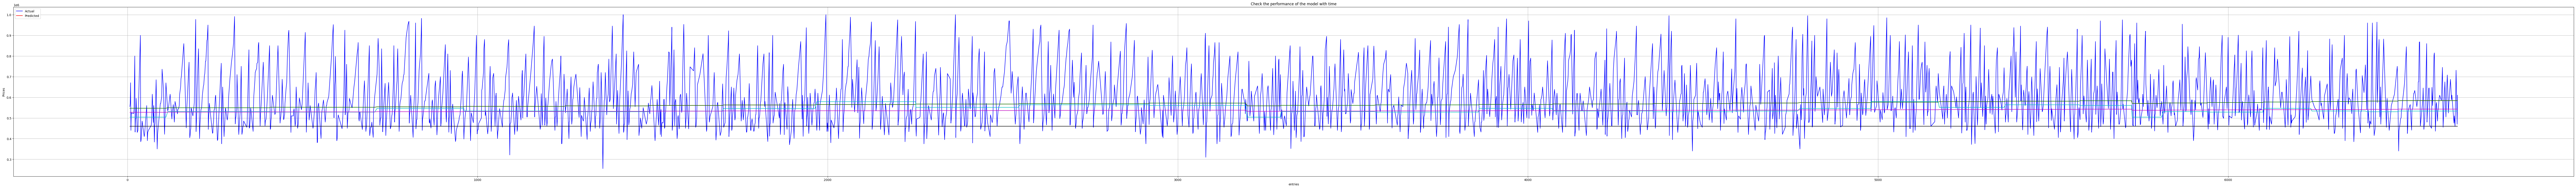

In [24]:
plt.figure(figsize=(150, 10))
plt.plot(price_pred['price'] , 'b')
plt.plot(price_pred['pricePredRidge']  , 'r')
plt.plot(price_pred['pricePredLR']  , 'g')
plt.plot(price_pred['pricePredRF']  , 'c')
plt.plot(price_pred['pricePredSVR']  , 'm')
plt.plot(price_pred['pricePredDT']  , 'k')

plt.xlabel('entries')
plt.ylabel('Prices')
plt.title('Check the performance of the model with time')
plt.legend(['Actual', 'Predicted'], loc='upper left')

plt.grid(True)
plt.show()

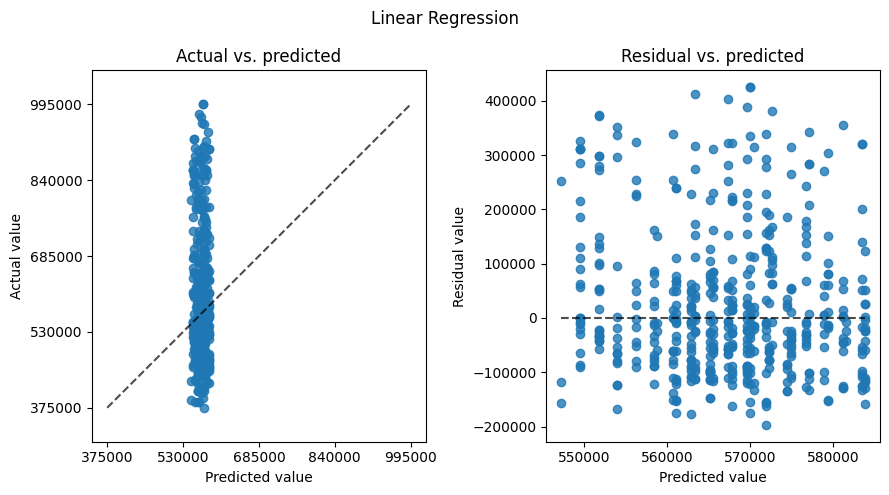

In [25]:
def _plot_model_predictions(y, y_pred, title):
    fig, axs = plt.subplots(ncols=2, figsize=(9, 5))

    PredictionErrorDisplay.from_predictions(
        y['price'],
        y_pred=y_pred,
        kind="actual_vs_predicted",
        subsample=500,
        ax=axs[0],
        random_state=0,
        # scatter_kwargs={'color': my_color}
    )
    axs[0].set_title("Actual vs. predicted")
    axs[0].set(xlabel = 'Predicted value', ylabel = 'Actual value')
    PredictionErrorDisplay.from_predictions(
        y['price'],
        y_pred=y_pred,
        kind="residual_vs_predicted",
        subsample=500,
        ax=axs[1],
        random_state=0,
        # scatter_kwargs={'color': my_color}
    )
    axs[1].set_title("Residual vs. predicted")
    axs[1].set(xlabel = 'Predicted value', ylabel = 'Residual value')
    fig.suptitle(title)
    fig.tight_layout()

_plot_model_predictions(price_pred, price_pred['pricePredLR'], "Linear Regression")

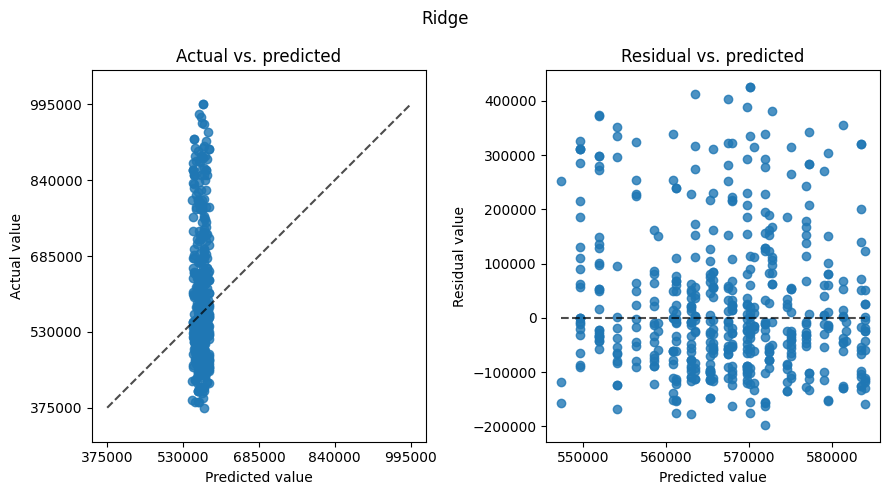

In [26]:
_plot_model_predictions(price_pred, price_pred['pricePredRidge'], "Ridge")

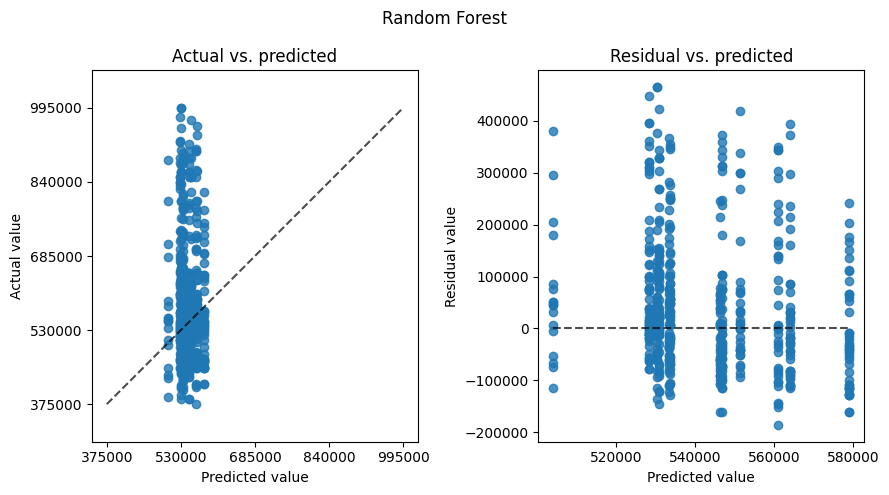

In [27]:
_plot_model_predictions(price_pred, price_pred['pricePredRF'], "Random Forest")

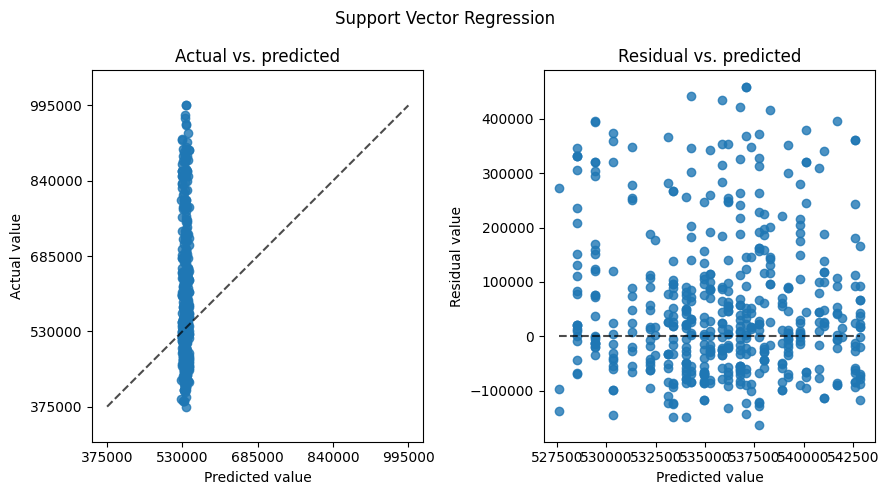

In [28]:
_plot_model_predictions(price_pred, price_pred['pricePredSVR'], "Support Vector Regression")

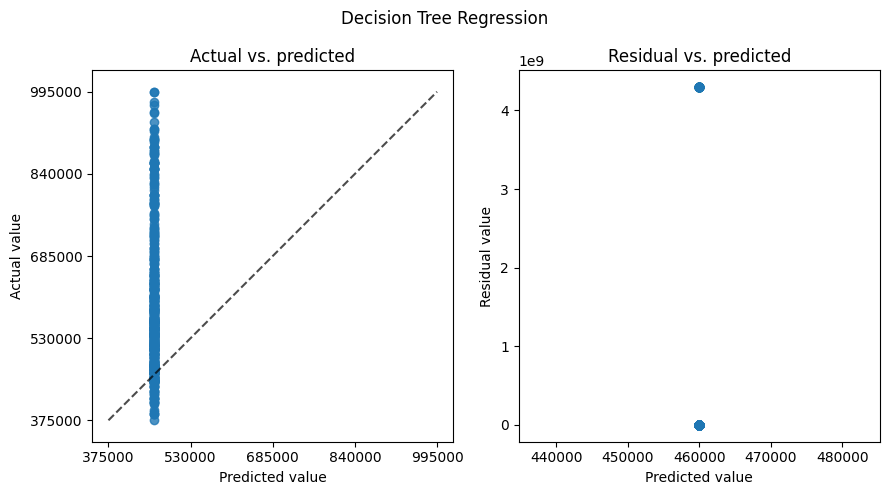

In [29]:
_plot_model_predictions(price_pred, price_pred['pricePredDT'], "Decision Tree Regression")

Results for added features:

Previous MSE without tuning: 23072359149.09601

NMSE on training set: -48892.36520544706 / -42119.596094051114


Results for no added features:
16508624544.933722
16509230502.221066
0.4961237710945755
0.49610527606659827

Polynomial degree 1: train score=0.3, test score=0.36
Polynomial degree 2: train score=0.31, test score=0.36
Polynomial degree 3: train score=0.31, test score=0.36
Polynomial degree 6: train score=0.3, test score=0.35
Polynomial degree 10: train score=0.27, test score=0.28
Polynomial degree 20: train score=0.24, test score=0.22

Best hyperparameters: {'alpha': 0.010857615124371604, 'fit_intercept': True, 'solver': 'sag'}
Best score: -99570.94705387855

Results for scaled bedroom:

Polynomial degree 1: train score=0.3, test score=0.17
Polynomial degree 2: train score=0.31, test score=0.16
Polynomial degree 3: train score=0.31, test score=0.16
Polynomial degree 6: train score=0.31, test score=0.08
Polynomial degree 10: train score=0.31, test score=0.01
Polynomial degree 20: train score=0.14, test score=-0.07

Best hyperparameters: {'alpha': 0.00010275874247202786, 'fit_intercept': True, 'solver': 'sag'}
Best score: -99570.94170378348

22759839519.716488
22760447317.200882
0.30532419121453624
0.30530564002006566


TODO:
- Prediction over actual truth
- residual vs. predicted